### Importing Dataset and Libraries




*   Use the following link to download the dataset named "credit_card_default_df.xlsx" and the SVM Library "svm_utils.py" 
*  Link - https://drive.google.com/drive/folders/1BlV5XcKQq6_ytRDAVVZobwGsqswNpr82?usp=share_link

*   If using Colab, please upload svm_utils.py file in the sidebar and the dataset in the Loading Dataset section of Notebook.
*   If using Jupyter, please copy the downloaded files to the same folder as the python file and comment out the Loading Dataset section







In [ ]:
#@title Libraries
!pip install xlrd=='1.2.0'
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
from scipy.stats import norm
import dataclasses as dataclasses
from dataclasses import dataclass
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize
from numpy.matrixlib.defmatrix import concatenate
from scipy import optimize
from svm_utils import *
from sklearn import metrics
from scipy.stats import norm
from pandas.core.common import random_state
from keras.models import Sequential
from keras.layers import Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Loading Dataset

In [ ]:
#Comment out this if using Jupyter
#OR you can upload on sidebar and hit "cancel upload" as well
from google.colab import files
file = files.upload()
df = pd.read_excel("credit_card_default_df.xlsx")
df.head()

Saving credit_card_default_df.xlsx to credit_card_default_df (2).xlsx


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Target
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Exploratory Data Analysis

In [ ]:
# Checking for null values
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Target       0
dtype: int64

The dataset contains no null values.

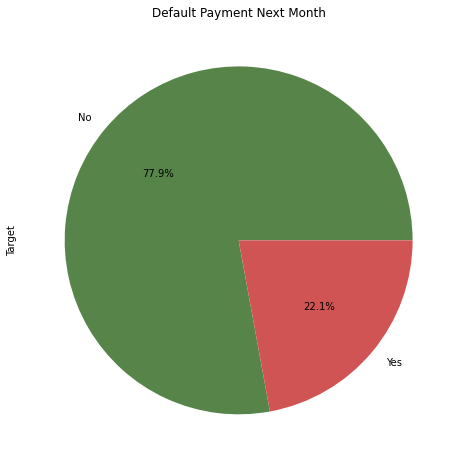

In [ ]:
# Proportion of target variable in the dataset

df['Target'].map({0:'No', 1:'Yes'}).value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(10,8), colors = ['#578549', '#d15454'])
plt.title('Default Payment Next Month')
plt.show()

The dataset is imbalanced. 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


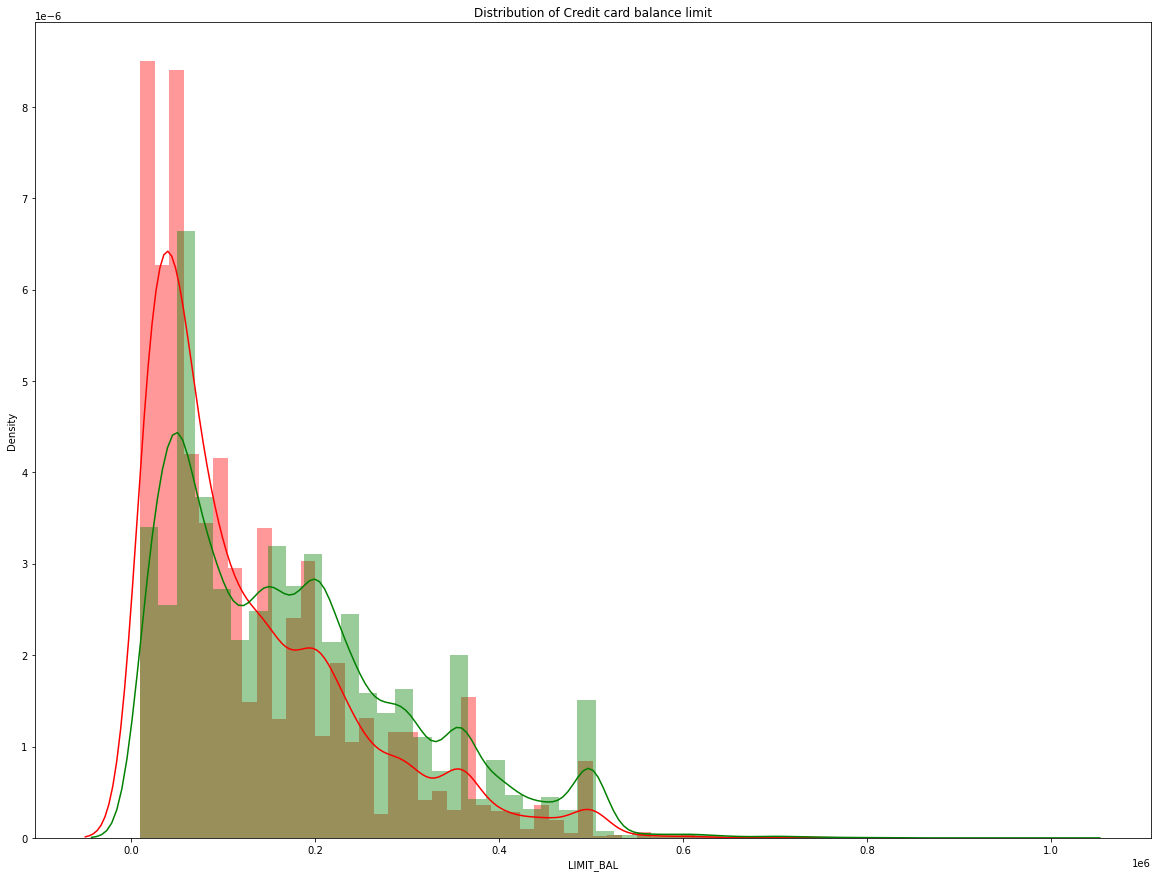

In [ ]:
# Distribution of credit card balance in both default and not default cases
plt.figure(figsize=(20,15))
sns.distplot(df['LIMIT_BAL'].loc[df['Target'] == 1], color='red')
sns.distplot(df['LIMIT_BAL'].loc[df['Target'] == 0], color='green')
plt.title('Distribution of Credit card balance limit')
plt.show()

In the chart, the lower the credit limit the higher the cases of defaulting payment next month. We know that the credit score is affected by default payments which results in banks giving less credit limit tp those clients. Moreover, higher credit limit is offered to customers with good payment history, therefore chances of them defaulting a payment is lower.
It can also be noted that this data is skewed.

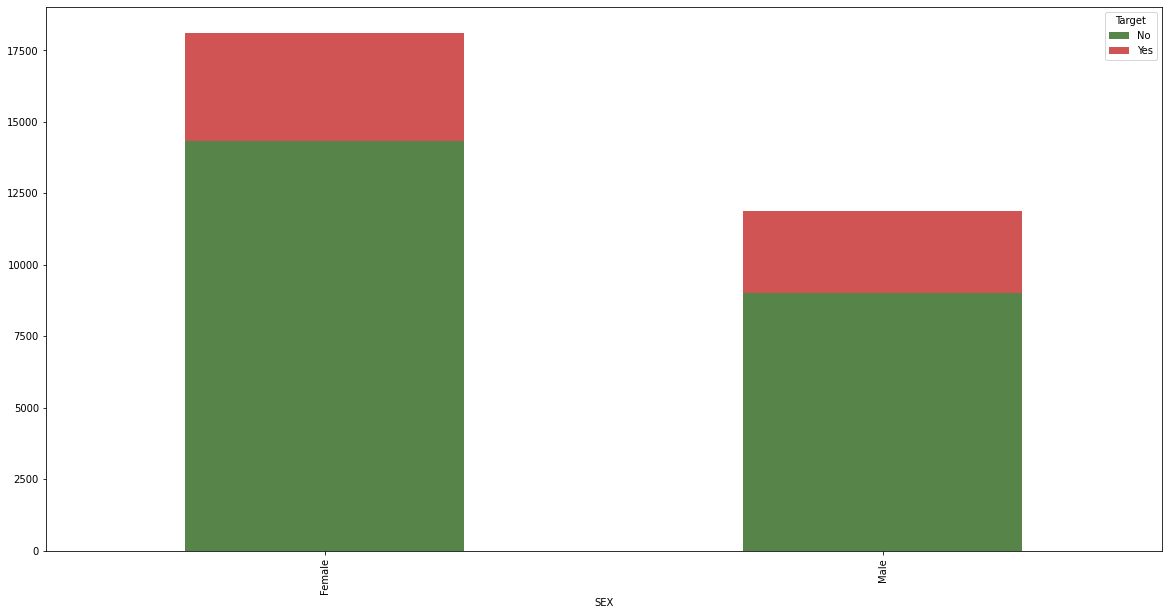

In [ ]:
# Gender distribution of default type
df_group = df.groupby(['SEX', 'Target']).size().reset_index(name='counts')
df_group['Target'] = df_group['Target'].map({0:'No', 1:'Yes'})
df_group['SEX'] = df_group['SEX'].map({1:'Male', 2:'Female'})
df_group = df_group.pivot_table(index=['SEX'], 
                                columns='Target', 
                                values='counts', aggfunc='first')
df_group.plot(kind='bar', stacked=True, figsize=(20,10), color = ['#578549', '#d15454'])

There are more females in this data but the percentage of females who default on a payment is less than males by a small percentage. 

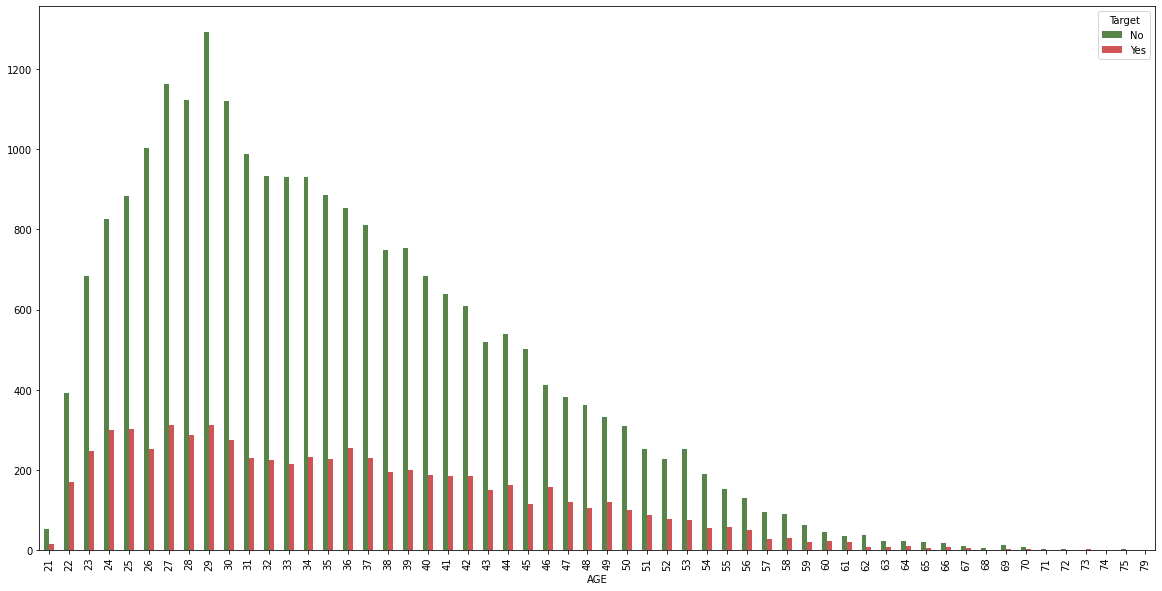

In [ ]:
# Default payment distribution over age
df_group = df.groupby(['AGE', 'Target']).size().reset_index(name='counts')
df_group['Target'] = df_group['Target'].map({0:'No', 1:'Yes'})
df_group = df_group.pivot_table(index=['AGE'], 
                                columns='Target', 
                                values='counts', aggfunc='first')
df_group.plot(kind='bar', figsize=(20,10), color = ['#578549', '#d15454'])

People in their early 20's and early 30's tend to more likely default on a payment.

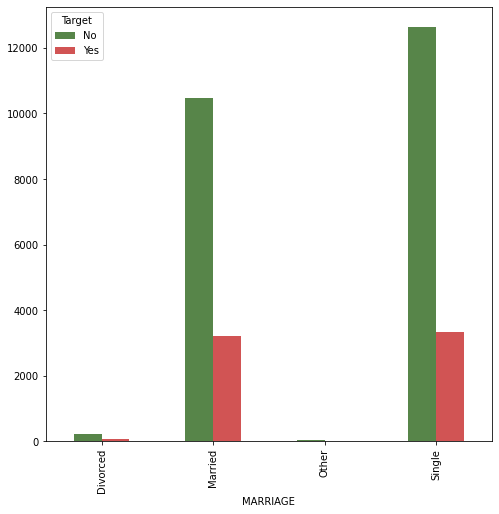

In [ ]:
# Proportion of default payment with respect to marital status
df_group = df.groupby(['MARRIAGE', 
                       'Target']).size().reset_index(name='counts')
df_group['Target'] = df_group['Target'].map({0:'No', 1:'Yes'})
df_group['MARRIAGE'] = df_group['MARRIAGE'].map({1:'Married', 
                                                 2:'Single', 
                                                 3:'Divorced', 0:'Other'})
df_group = df_group.pivot_table(index=['MARRIAGE'], 
                                columns='Target', 
                                values='counts', aggfunc='first')

df_group.plot(kind='bar', figsize=(8,8), color = ['#578549', '#d15454'])

People who are married tend to default on a payment more which corresponds to more responsibility faced by married people and more commitments than people who are single.

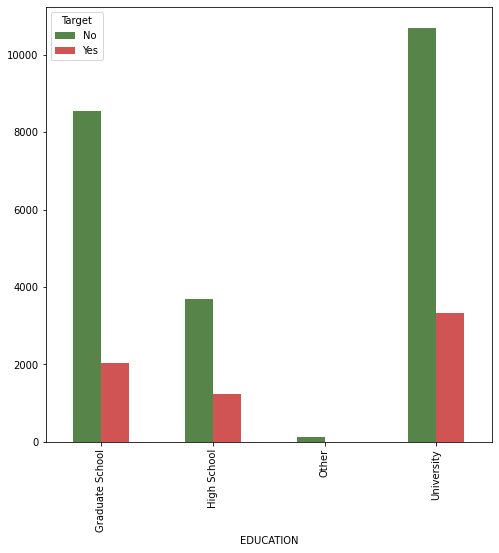

In [ ]:
# Distribution of default payment with respect to education level
df_group = df.groupby(['EDUCATION', 'Target']).size().reset_index(name='counts')
df_group['Target'] = df_group['Target'].map({0:'No', 1:'Yes'})
df_group['EDUCATION'] = df_group['EDUCATION'].map({1:'Graduate School', 
                                                   2:'University', 
                                                   3:'High School', 
                                                   4:'Other', 5:'Other', 
                                                   6:'Other'})
df_group = df_group.pivot_table(index=['EDUCATION'], 
                                columns='Target', 
                                values='counts', aggfunc='first')
df_group.plot(kind='bar', figsize=(8,8), color = ['#578549', '#d15454'])

The proportion of default payment among high high students is more than that of people who have attended university and graduate school.

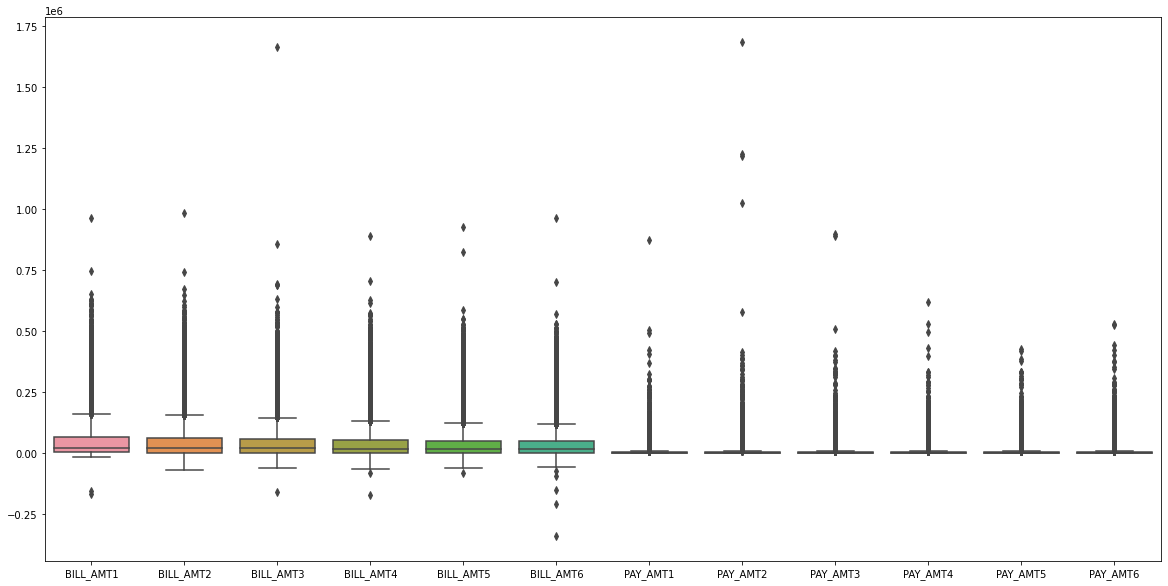

In [ ]:
# Boxplot of Bill Amount and Pay Amount
plt.figure(figsize=(20,10))
cols = ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
sns.boxplot(data=df[cols])

There are many outliers in these features but due to lack of domain knowledge of the dataset we are not changing or removing the values.

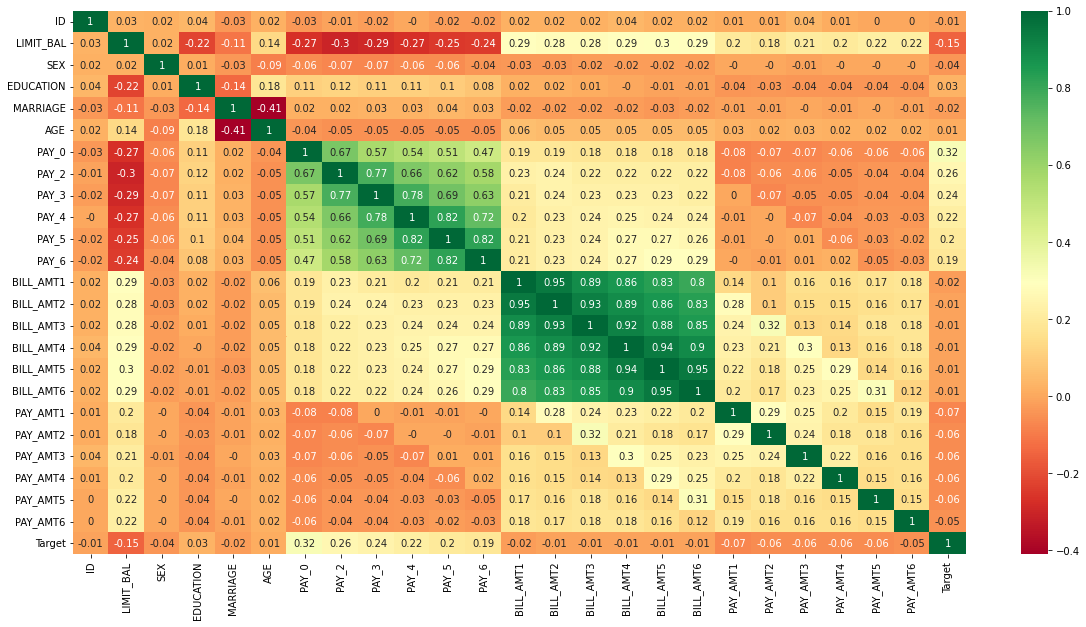

In [ ]:
# Correlation between different features
corr = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(round(corr,2), annot=True, cmap='RdYlGn')

Each bill amount is highly correlated with the bill amount for its consecutive month. 

# Data Cleaning and Pre-processing

In [ ]:
df = df.drop(columns = ['ID'])
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Target
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


We drop the ID columns as it is just an index or key for the row values and it is not useful to include in our analysis or model training.

In [ ]:
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

Education is a categorical variable where the values of 0, 5, 6 is mentioned as unknown. Since these are only a few instances out of our entire dataset, we combine these values as a single category of 4 which is described as others

In [ ]:
df.loc[(df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0),
       'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [ ]:
df.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Marriage is a categorical variable for which the category 3 is described as divorced and category 0 is others. Since these are very few instances out of many, we will combine the categories to category 3.

In [ ]:
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [ ]:
df.loc[(df.PAY_0 == -2) | (df.PAY_0 == -1) | (df.PAY_0 == 0), 'PAY_0'] = 0
df.loc[(df.PAY_2 == -2) | (df.PAY_2 == -1) | (df.PAY_2 == 0), 'PAY_2'] = 0
df.loc[(df.PAY_3 == -2) | (df.PAY_3 == -1) | (df.PAY_3 == 0), 'PAY_3'] = 0
df.loc[(df.PAY_4 == -2) | (df.PAY_4 == -1) | (df.PAY_4 == 0), 'PAY_4'] = 0
df.loc[(df.PAY_5 == -2) | (df.PAY_5 == -1) | (df.PAY_5 == 0), 'PAY_5'] = 0
df.loc[(df.PAY_6 == -2) | (df.PAY_6 == -1) | (df.PAY_6 == 0), 'PAY_6'] = 0
df.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Target
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,0,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,0,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The columns Pay_x are categorical columns where 'x' is the number of months and the values are number of months for which the payment is defaulted consecutively. However, the values '-2' is described as No activity or no consumption of credit limit balance, the value '-1' is described as balance paid in full and the value '0' is described as balance paid in full but credit limit is revolved for the month.
All of these values can be combined into a single category since they are not indicative of any type of credit card payment default. 

# Feature Engineering

In [ ]:
df['Avg_exp_1m'] = ((df['BILL_AMT6'] - df['PAY_AMT6'])/df['LIMIT_BAL'])
df['Avg_exp_2m'] = ((df['BILL_AMT6'] + (df['BILL_AMT5'] - df['PAY_6'] - 
                                       df['PAY_AMT5']))/2) / df['LIMIT_BAL']
df['Avg_exp_3m'] = ((df['BILL_AMT6'] + df['BILL_AMT5'] + df['BILL_AMT4'] -
                     df['PAY_6'] - df['PAY_AMT5'] - 
                     df['PAY_AMT4'])/3) / df['LIMIT_BAL']
df['Avg_exp_4m'] = ((df['BILL_AMT6'] + df['BILL_AMT5'] + df['BILL_AMT4'] + 
                     df['BILL_AMT3'] - df['PAY_6'] - df['PAY_AMT5'] - 
                     df['PAY_AMT4'] - df['PAY_AMT3'])/4) / df['LIMIT_BAL']
df['Avg_exp_5m'] = ((df['BILL_AMT6'] + df['BILL_AMT5'] + df['BILL_AMT4'] + 
                     df['BILL_AMT3'] + df['BILL_AMT2'] - df['PAY_6'] - 
                     df['PAY_AMT5'] - df['PAY_AMT4'] - df['PAY_AMT3'] - 
                     df['PAY_AMT2'])/5) / df['LIMIT_BAL']
df['Avg_exp_6m'] = ((df['BILL_AMT6'] + df['BILL_AMT5'] + df['BILL_AMT4'] + 
                     df['BILL_AMT3'] + df['BILL_AMT2'] + df['BILL_AMT1'] - 
                     df['PAY_6'] - df['PAY_AMT5'] - df['PAY_AMT4'] - 
                     df['PAY_AMT3'] - df['PAY_AMT2'] - df['PAY_AMT1']
                     )/6) / df['LIMIT_BAL']

These features are basically an average expenditure ranging from 1 month to 6 months. Hence, Avg_exp_1m captures the average expenditure of a client for the past one month and Avg_exp_2m captures the average expenditure of a client for the past 2 months and so on till Avg_exp_6m which captures the average expediture of a client on a particular card for 6 months. 

In [ ]:
df['Utilization_6'] = (df.LIMIT_BAL - df.BILL_AMT6) / df.LIMIT_BAL
df['Utilization_5'] = (df.LIMIT_BAL - df.BILL_AMT5) / df.LIMIT_BAL
df['Utilization_4'] = (df.LIMIT_BAL - df.BILL_AMT4) / df.LIMIT_BAL
df['Utilization_3'] = (df.LIMIT_BAL - df.BILL_AMT3) / df.LIMIT_BAL
df['Utilization_2'] = (df.LIMIT_BAL - df.BILL_AMT2) / df.LIMIT_BAL
df['Utilization_1'] = (df.LIMIT_BAL - df.BILL_AMT1) / df.LIMIT_BAL

These features basically capture the total utilization of the available credit limit for those months where we have the available data.

# Preparing Data for Model Implementation

Splitting the Data into Training and Test Datasets

In [ ]:
X = df.iloc[:, df.columns!='Target']
y = df.iloc[:, df.columns=='Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=18)

In [ ]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,Avg_exp_3m,Avg_exp_4m,Avg_exp_5m,Avg_exp_6m,Utilization_6,Utilization_5,Utilization_4,Utilization_3,Utilization_2,Utilization_1
26871,290000,1,1,1,45,0,0,0,0,0,...,0.011154,0.002058,0.001402,0.001268,0.981210,0.975545,0.966393,0.991462,0.992652,0.992014
6839,500000,2,1,1,51,0,0,0,0,0,...,0.064435,0.066962,0.073458,0.033969,0.877942,0.844344,0.951110,0.925456,0.826016,0.989490
24940,60000,1,2,1,38,0,0,2,0,0,...,0.972583,0.997792,1.025310,1.043119,0.059033,-0.000800,-0.059317,-0.123417,-0.185383,-0.215500
19755,20000,2,2,1,42,2,0,0,0,0,...,0.910433,0.882500,0.858670,0.832033,0.040250,0.067350,0.085550,0.136100,0.172000,0.222400
4217,50000,1,2,2,33,1,2,2,2,2,...,0.838733,0.813870,0.816388,0.807187,0.022700,0.160680,0.144380,0.192720,0.173540,0.196820


In [ ]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'Avg_exp_1m', 'Avg_exp_2m', 'Avg_exp_3m', 'Avg_exp_4m', 'Avg_exp_5m',
       'Avg_exp_6m', 'Utilization_6', 'Utilization_5', 'Utilization_4',
       'Utilization_3', 'Utilization_2', 'Utilization_1'],
      dtype='object')

Since the Data has a few features that we added which are scaled, as well as a few features that are categorical, we scale the rest of the features using a Standard Scaler from sklearn. The Standard Scaler fits the Scaler according to the values in the Training dataset and transforms it into a scaled dataset. We further use the same scaler fitted on training set to scale the test dataset as well. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_scale = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,Avg_exp_3m,Avg_exp_4m,Avg_exp_5m,Avg_exp_6m,Utilization_6,Utilization_5,Utilization_4,Utilization_3,Utilization_2,Utilization_1
26871,0.932871,1,1,1,1.035773,0,0,0,0,0,...,0.011154,0.002058,0.001402,0.001268,0.981210,0.975545,0.966393,0.991462,0.992652,0.992014
6839,2.538253,2,1,1,1.687621,0,0,0,0,0,...,0.064435,0.066962,0.073458,0.033969,0.877942,0.844344,0.951110,0.925456,0.826016,0.989490
24940,-0.825404,1,2,1,0.275284,0,0,2,0,0,...,0.972583,0.997792,1.025310,1.043119,0.059033,-0.000800,-0.059317,-0.123417,-0.185383,-0.215500
19755,-1.131191,2,2,1,0.709849,2,0,0,0,0,...,0.910433,0.882500,0.858670,0.832033,0.040250,0.067350,0.085550,0.136100,0.172000,0.222400
4217,-0.901851,1,2,2,-0.267923,1,2,2,2,2,...,0.838733,0.813870,0.816388,0.807187,0.022700,0.160680,0.144380,0.192720,0.173540,0.196820


In [ ]:
y_train.head()

,Target
26871,0
6839,0
24940,0
19755,1
4217,1


Since the target was categorical and not continuous, we didn't need to scale the Target variable and hence, we join the two dataframes by matching their indexes so as to avoid data quality issues. This joining process is performed for both the Training and Test dataset.

In [ ]:
Train = pd.merge(X_train, y_train, left_index=True, right_index=True)
Train_SVM = Train
Train_Balance = Train
Train = np.array(Train, dtype=np.float64)
Train

array([[ 0.9328715 ,  1.        ,  1.        , ...,  0.99265172,
         0.99201379,  0.        ],
       [ 2.5382534 ,  2.        ,  1.        , ...,  0.826016  ,
         0.98949   ,  0.        ],
       [-0.82540392,  1.        ,  2.        , ..., -0.18538333,
        -0.2155    ,  0.        ],
       ...,
       [ 0.85642474,  2.        ,  2.        , ...,  1.        ,
         0.99860714,  1.        ],
       [ 0.55063771,  2.        ,  1.        , ...,  0.66729583,
        -0.40955833,  0.        ],
       [-1.13119095,  2.        ,  2.        , ...,  0.5781    ,
         0.3629    ,  0.        ]])

In [ ]:
Test = pd.merge(X_test, y_test, left_index=True, right_index=True)
Test_SVM = Test
Test = np.array(Test, dtype=np.float64)
Test

array([[-1.13119095,  1.        ,  3.        , ...,  1.011     ,
         0.9915    ,  0.        ],
       [ 0.09195717,  2.        ,  2.        , ...,  1.        ,
         0.99727222,  0.        ],
       [-0.44317013,  2.        ,  2.        , ...,  0.99508182,
         0.99508182,  0.        ],
       ...,
       [-0.90185068,  2.        ,  2.        , ..., -0.0221    ,
         0.02998   ,  0.        ],
       [-1.13119095,  2.        ,  1.        , ...,  1.        ,
         0.66335   ,  0.        ],
       [-0.97829743,  2.        ,  1.        , ...,  0.6965    ,
         0.75105   ,  0.        ]])

# Models

In [ ]:
#@title Model Evaluation Metrics
def model_evaluation(name_of_model, y_test, y_pred):
    import json
    from sklearn import metrics
    evaluation = {}
    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
    evaluation.update({"model":name_of_model,"accuracy": acc,"precision":prec,
                       "recall":rec,"f1 score":f1,
                       "roc_auc_score":roc_auc_score})
    print(json.dumps(evaluation, indent=4, sort_keys=True))
    return evaluation

In [ ]:
#@title Logistic Regression { vertical-output: true }
import string
@dataclass
class LogisticRegression:

    maxIteration: int
    learningRate: float
    epsilon: float
    train: np.array
    test: np.array


    def __post_init__(self):
        self.train_X, self.test_X, self.train_y, self.test_y = self.dataReader()
        self.train_X = self.addX0(self.train_X)
        self.test_X = self.addX0(self.test_X)
        

    def dataReader(self):

        train_df = self.train
        test_df = self.test
        train_X, train_y = train_df[:, :-1], train_df[:, -1]
        test_X, test_y = test_df[:, :-1], test_df[:, -1]
        return train_X, test_X, train_y, test_y


    def addX0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def sigmoid(self, z):
        sig = 1 / (1+np.exp(-z))
        return sig #1 / (1+np.exp(-z))

    def predict(self, X):
        return X.dot(self.w)

    def costFunction(self, X, y):
        #log loss
        #sigm = self.sigmoid(self.predict(X))
        #loss = y.dot(np.log(sigm)) + (1-y).dot(np.log(1 - sigm))
        #cost = -loss.sum()

        #second approach
        sigm = self.predict(X)
        cost = (np.log(np.ones(X.shape[0]) + np.exp(sigm)) - sigm*y).sum()

        return cost

    def costDerivative(self, X, y):
        sigm = self.sigmoid(self.predict(X))
        grad = (sigm - y).dot(X)
        return grad

    def gradientDescent(self, X, y):
        self.errors= {}
        lasterror = float('inf')
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate*self.costDerivative(X, y)
            currenterror = self.costFunction(X, y)
            self.errors.update({i+1: currenterror})
            diff = abs(lasterror - currenterror)
            lasterror = currenterror
            if diff < self.epsilon:
                print("Model Stopped Learning")
                break

        self.plot_cost(self.errors)

    def evaluate(self, y, y_hat):

        y = (y == 1)
        y_hat = (y_hat == 1)
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        f_score = 2 * precision * recall / (precision + recall)
        return f_score, precision, recall

    def plot_cost(self, cost_dict): 
        s = list(cost_dict.keys())
        t = list(cost_dict.values())
        plt.plot(s,t)
        plt.xlabel("Iterations")
        plt.ylabel("Costs")

    def fit(self):
        self.w = np.ones(self.train_X.shape[1], dtype = np.float64)
        self.gradientDescent(self.train_X, self.train_y)
        y_hat = np.around(self.sigmoid(self.predict(self.train_X)))
        f_score, precision, recall = self.evaluate(self.train_y, y_hat)
        accuracy = metrics.accuracy_score(self.train_y, y_hat)
        print("\nFor Training \
        Accuracy is {} and \
        F-1 Score is {} and \
         Precision is {} and \
          Recall is {}".format(accuracy, f_score, precision, recall))
        y_hat = np.around(self.sigmoid(self.predict(self.test_X)))
        f_score, precision, recall = self.evaluate(self.test_y, y_hat)
        accuracy = metrics.accuracy_score(self.test_y, y_hat)
        print("For Test \
        Accuracy is {} and \
        F-1 Score is {} and \
         Precision is {} and \
          Recall is {}".format(accuracy, f_score, precision, recall))

100%|██████████| 4000/4000 [00:58<00:00, 68.50it/s] 



For Training         Accuracy is 0.816625 and         F-1 Score is 0.43337195828505215 and          Precision is 0.6718562874251497 and           Recall is 0.3198403648802737
For Test         Accuracy is 0.8118333333333333 and         F-1 Score is 0.43237807943690304 and          Precision is 0.6991869918699187 and           Recall is 0.3129548762736536


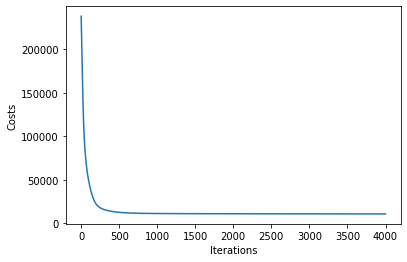

In [ ]:
lr = LogisticRegression(train = Train, test = Test, epsilon=0, 
                        learningRate=0.1e-5, maxIteration=4000)
lr.fit()

In [ ]:
#@title K-Fold Cross Validation using Logistic Regression { vertical-output: true }
import string
@dataclass
class LogisticRegression:

    maxIteration: int
    learningRate: float
    epsilon: float
    train: np.array
    test: np.array


    def __post_init__(self):
        self.train_X, self.test_X, self.train_y, self.test_y = self.dataReader()
        self.train_X = self.addX0(self.train_X)
        self.test_X = self.addX0(self.test_X)
        

    def dataReader(self):

        train_df = self.train
        test_df = self.test
        train_X, train_y = train_df[:, :-1], train_df[:, -1]
        test_X, test_y = test_df[:, :-1], test_df[:, -1]
        return train_X, test_X, train_y, test_y


    def addX0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def sigmoid(self, z):
        sig = 1 / (1+np.exp(-z))
        return sig #1 / (1+np.exp(-z))

    def predict(self, X):
        return X.dot(self.w)

    def costFunction(self, X, y):
        #log loss
        #sigm = self.sigmoid(self.predict(X))
        #loss = y.dot(np.log(sigm)) + (1-y).dot(np.log(1 - sigm))
        #cost = -loss.sum()

        #second approach
        sigm = self.predict(X)
        cost = (np.log(np.ones(X.shape[0]) + np.exp(sigm)) - sigm*y).sum()

        return cost

    def costDerivative(self, X, y):
        sigm = self.sigmoid(self.predict(X))
        grad = (sigm - y).dot(X)
        return grad

    def gradientDescent(self, X, y):
        self.errors= {}
        lasterror = float('inf')
        for i in tqdm(range(self.maxIteration)):
            self.w = self.w - self.learningRate*self.costDerivative(X, y)
            currenterror = self.costFunction(X, y)
            self.errors.update({i+1: currenterror})
            diff = abs(lasterror - currenterror)
            lasterror = currenterror
            if diff < self.epsilon:
                print("Model Stopped Learning")
                break

        self.plot_cost(self.errors)

    def evaluate(self, y, y_hat):

        y = (y == 1)
        y_hat = (y_hat == 1)
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        f_score = 2 * precision * recall / (precision + recall)
        return f_score, precision, recall

    def plot_cost(self, cost_dict): 
        s = list(cost_dict.keys())
        t = list(cost_dict.values())
        plt.plot(s,t)
        plt.xlabel("Iterations")
        plt.ylabel("Costs")

    def fit(self):
        self.w = np.ones(self.train_X.shape[1], dtype = np.float64)
        self.gradientDescent(self.train_X, self.train_y)
        y_hat = np.around(self.sigmoid(self.predict(self.train_X)))

100%|██████████| 2000/2000 [00:13<00:00, 153.06it/s]


{
    "accuracy": 0.8095,
    "f1 score": 0.4218512898330804,
    "model": "K-Fold-1",
    "precision": 0.6915422885572139,
    "recall": 0.3034934497816594,
    "roc_auc_score": 0.6316429635419322
}


100%|██████████| 2000/2000 [00:19<00:00, 100.41it/s]


{
    "accuracy": 0.8096666666666666,
    "f1 score": 0.42842842842842843,
    "model": "K-Fold-2",
    "precision": 0.6858974358974359,
    "recall": 0.31149927219796214,
    "roc_auc_score": 0.6345650273657343
}


100%|██████████| 2000/2000 [00:13<00:00, 147.10it/s]


{
    "accuracy": 0.8091666666666667,
    "f1 score": 0.4225920322743319,
    "model": "K-Fold-3",
    "precision": 0.6880131362889984,
    "recall": 0.3049490538573508,
    "roc_auc_score": 0.6319384266260382
}


100%|██████████| 2000/2000 [00:11<00:00, 167.55it/s]


{
    "accuracy": 0.8093333333333333,
    "f1 score": 0.42280524722502527,
    "model": "K-Fold-4",
    "precision": 0.6891447368421053,
    "recall": 0.3049490538573508,
    "roc_auc_score": 0.6320465113644731
}


100%|██████████| 2000/2000 [00:17<00:00, 114.43it/s]


{
    "accuracy": 0.8093333333333333,
    "f1 score": 0.4291417165668663,
    "model": "K-Fold-5",
    "precision": 0.6825396825396826,
    "recall": 0.3129548762736536,
    "roc_auc_score": 0.6348604904498402
}
      model  accuracy  precision    recall  f1 score  roc_auc_score
0  K-Fold-1  0.809500   0.691542  0.303493  0.421851       0.631643
1  K-Fold-2  0.809667   0.685897  0.311499  0.428428       0.634565
2  K-Fold-3  0.809167   0.688013  0.304949  0.422592       0.631938
3  K-Fold-4  0.809333   0.689145  0.304949  0.422805       0.632047
4  K-Fold-5  0.809333   0.682540  0.312955  0.429142       0.634860


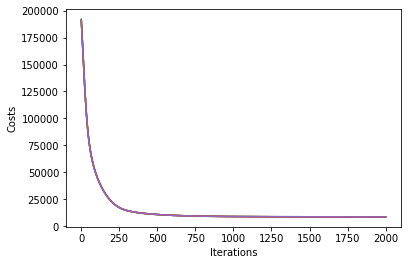

In [ ]:
split = Train

from sklearn.model_selection import KFold
kf5 = KFold(n_splits=5, shuffle=True)

count = 1
lists = pd.DataFrame(columns = ['model', 'accuracy', 'precision', 'recall',
                                'f1 score', 'roc_auc_score'])

for train_index, test_index in kf5.split(split):
    lr1 = LogisticRegression(train = Train[train_index], test = Train[test_index],
                            epsilon=0, learningRate=0.1e-5, maxIteration=2000)
    lr1.fit()
    pred = np.around(lr1.sigmoid(lr1.predict(lr1.addX0(Test[:, :-1]))))
    actual = Test[:, -1]
    
    result = model_evaluation('K-Fold-'+(str(count)), actual, pred)
    
    lists.loc[len(lists)] = result.values()
    count+=1
print(lists.head())

In [ ]:
#@title SVM Classifier


class maxMarginClassifier:

      def __init__(self, C, train, test):
          self.C = C
          self.train = train
          self.test = test

      def dataReader(self):

        train_df = self.train
        test_df = self.test

        train_X, train_y = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        test_X, test_y = test_df.iloc[:, :-1], test_df.iloc[:, -1]
        train_y = train_y.replace(0, -1)

        train_X = train_X.sample(frac = 0.02, replace = False, 
                                 random_state = 18).to_numpy()
        train_y = train_y.sample(frac = 0.02, replace = False,
                                 random_state = 18).to_numpy()


        return train_X, test_X, train_y, test_y

      def fit(self):

          self.train_X, self.test_X, self.train_y, self.test_y = self.dataReader()
          N = len(self.train_y)
          Xy = self.train_X*self.train_y[:, np.newaxis]
          GramXy = np.matmul(Xy, Xy.T)

          def Ld0(G, alpha):
              obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
              return obj_fn 
          def partialDerivativeLd0(G, alpha):
              par_der = np.ones_like(alpha) - alpha.dot(G)
              return par_der
          
          A = np.vstack((-np.eye(N), np.eye(N)))
          b = concatenate((np.zeros(N), self.C*np.ones(N)))
          constraints = ({'type': 'eq', 'fun': lambda a:np.dot(a, self.train_y), 'jac': lambda a: self.train_y},
                         {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})
          
          alpha = np.ones(N)
          optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                     x0 = alpha,
                                     method = 'SLSQP',
                                     jac = lambda a: -partialDerivativeLd0(GramXy, a),
                                     constraints=constraints)
          
          self.alpha = optRes.x
          self.w = np.sum(self.alpha[:, np.newaxis]*Xy, axis = 0)

          epsilon = 1e-4
          self.supportVectors = self.train_X[self.alpha > epsilon]
          self.supportLabels = self.train_y[self.alpha > epsilon]

          b = []
          for i in range(len(self.supportLabels)):
              b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
              b.append(b_i)

          self.intercept = sum(b)/len(b)
          pred = self.predict(self.test_X)
          pred = pred.replace(-1, 0)
          actual = self.test_y
          print('Accuracy is ', metrics.accuracy_score(pred, actual))
          print('Confusion Matrix is \n', metrics.confusion_matrix(actual, pred))
          print('F1 Score is ', metrics.f1_score(actual, pred))
          print('Precision is ', metrics.precision_score(actual, pred))
          print('Recall is ', metrics.recall_score(actual, pred))

      def predict(self, X):
          return 2*(np.matmul(X, self.w) + self.intercept > 0) - 1

In [ ]:
model = maxMarginClassifier(C = 5, train = Train_SVM, test = Test_SVM)
model.fit()

Accuracy is  0.7858333333333334
Confusion Matrix is 
 [[4197  429]
 [ 856  518]]
F1 Score is  0.4463593278759156
Precision is  0.5469904963041182
Recall is  0.37700145560407566


### SVM Classifier with Kernel Trick

SVM Classifier has a major assumption that the data given is linearly seperable. However, that might not be the case with our dataset and hence we use a kernel that can successfully seperate data that is not linearly seperable. The kernel trick along with speeding up also seperates data better between multiple classes. For our analysis, we use the Gaussian Radial Basis Function kernel for SVM Classifier. 

In [ ]:
#@title SVM Classifier with Kernel Trick { vertical-output: true }



class kernelMaxMarginClassifier:

      def __init__(self, C, train, test, kernel):
          self.C = C
          self.train = train
          self.test = test
          self.kernel = kernel

      def dataReader(self):

        train_df = self.train
        test_df = self.test

        train_X, train_y = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        test_X, test_y = test_df.iloc[:, :-1], test_df.iloc[:, -1]
        train_y = train_y.replace(0, -1)

        train_X = train_X.sample(frac = 0.01, replace = False, 
                                 random_state = 18).to_numpy()
        train_y = train_y.sample(frac = 0.01, replace = False,
                                 random_state = 18).to_numpy()


        return train_X, test_X, train_y, test_y

      def fit(self):

          self.train_X, self.test_X, self.train_y, self.test_y = self.dataReader()
          N = len(self.train_y)
          hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, self.train_X),
                                  1, self.train_X)  
          #Xy = self.train_X*self.train_y[:, np.newaxis]
          GramhXXy = hXX*np.matmul(self.train_y, self.train_y.T)
          #GramXy = np.matmul(Xy, Xy.T)

          def Ld0(G, alpha):
              obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
              return obj_fn 
          def partialDerivativeLd0(G, alpha):
              par_der = np.ones_like(alpha) - alpha.dot(G)
              return par_der
          
          A = np.vstack((-np.eye(N), np.eye(N)))
          b = concatenate((np.zeros(N), self.C*np.ones(N)))
          constraints = ({'type': 'eq', 'fun': lambda a:np.dot(a, self.train_y), 'jac': lambda a: self.train_y},
                         {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})
          
          alpha = np.ones(N)
          optRes = optimize.minimize(fun = lambda a: -Ld0(GramhXXy, a),
                                     x0 = alpha,
                                     method = 'SLSQP',
                                     jac = lambda a: -partialDerivativeLd0(GramhXXy, a),
                                     constraints=constraints)
          
          self.alpha = optRes.x
          self.w = np.sum(self.alpha[:, np.newaxis]*hXX, axis = 0)

          epsilon = 1e-6
          self.supportVectors = self.train_X[self.alpha > epsilon]
          self.supportLabels = self.train_y[self.alpha > epsilon]
          self.supportYalphas = self.train_y[self.alpha > epsilon]*self.alpha[self.alpha > epsilon]


          #b = []
          #for i in range(len(self.supportLabels)):
          #    b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i], self.w)
          #    b.append(b_i)

          #self.intercept = sum(b)/len(b)
          pred = pd.DataFrame(self.predict(self.test_X))
          pred = pred.replace(-1, 0)
          actual = self.test_y
          print('Accuracy is ', metrics.accuracy_score(pred, actual))
          print('Confusion Matrix is \n', metrics.confusion_matrix(actual, pred))
          print('F1 Score is ', metrics.f1_score(actual, pred))
          print('Precision is ', metrics.precision_score(actual, pred))
          print('Recall is ', metrics.recall_score(actual, pred))

      def predict(self, X):
          def predict1(x):
              x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
              x2 = x1 * self.supportYalphas
              return np.sum(x2)
          func = np.apply_along_axis(predict1, 1, X)
          return 2*(func > 0) - 1

In [ ]:
#@title Gaussian Radial Basis Function Kernel
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

In [ ]:
ksvm = kernelMaxMarginClassifier(C=5, train=Train_SVM, test=Test_SVM, kernel=GRBF)
ksvm.fit()

Accuracy is  0.7043333333333334
Confusion Matrix is 
 [[3734  892]
 [ 882  492]]
F1 Score is  0.3567802755620015
Precision is  0.3554913294797688
Recall is  0.35807860262008734


In [ ]:
#@title Gaussian Naive Bayes Classifier


class GaussianNaiveBayes:


    def __init__(self, train, test) -> None:
        self.train_df = train
        self.test_df = test
    
    def datasetReader(self):
        train_df,test_df=np.array(self.train_df,dtype=np.float64),np.array(self.test_df,dtype=np.float64)
        self.X_train,self.y_train = train_df[:, :-1], train_df[:, -1]
        self.X_test,self.y_test = test_df[:, :-1], test_df[:, -1]
        return self.X_train, self.y_train, self.X_test, self.y_test

    def fitDistribution(self, data):
        mean = np.mean(data)
        std = np.std(data)
        dist = norm(mean,std)
        return dist
    
    def probability(self, X, dist, prior):
        prob = prior
        count = 0
        for each in dist:
          prob = prob * each.pdf(X[count])
          count +=1
        return prob
    
    def fit(self):
        self.X_train, self.y_train, self.X_test, self.y_test = self.datasetReader()
        
        self.X0_train = self.X_train[self.y_train == 0] 
        self.X1_train = self.X_train[self.y_train == 1]
        
        self.prior_1 = len(self.X1_train)/ len(self.X_train)
        self.prior_0 = len(self.X0_train)/ len(self.X_train)

        self.dist0 = []
        self.dist1 = []

        for i in range(34):
          self.dist0.append(self.fitDistribution(self.X0_train[:,i]))
          self.dist1.append(self.fitDistribution(self.X1_train[:,i]))

        actual = self.y_test
        pred = self.predict()
        print('Accuracy is ', metrics.accuracy_score(actual, pred))
        print('Confusion Matrix is \n', metrics.confusion_matrix(actual, pred))
        print('F1 Score is ', metrics.f1_score(actual, pred))
        print('Precision is ', metrics.precision_score(actual, pred))
        print('Recall is ', metrics.recall_score(actual, pred))


    def predict(self):
        pred = []
        for sample, target in zip(self.X_test, self.y_test):
            py0 = self.probability(sample, self.dist0, self.prior_0)
            py1 = self.probability(sample, self.dist1, self.prior_1)
            
            y_predict = np.argmax([py0,py1])
            pred.append(y_predict)      
        return pred   

In [ ]:
gnb = GaussianNaiveBayes(train = Train, test = Test)
gnb.fit()

Accuracy is  0.7186666666666667
Confusion Matrix is 
 [[3560 1066]
 [ 622  752]]
F1 Score is  0.47117794486215536
Precision is  0.4136413641364136
Recall is  0.5473071324599709


In [ ]:
#@title K-Fold Cross Validation using Gaussian Naive Bayes Classifier


class kfGaussianNaiveBayes:


    def __init__(self, train, test) -> None:
        self.train_df = train
        self.test_df = test
    
    def datasetReader(self):
        train_df,test_df=np.array(self.train_df,dtype=np.float64),np.array(self.test_df,dtype=np.float64)
        self.X_train,self.y_train = train_df[:, :-1], train_df[:, -1]
        self.X_test,self.y_test = test_df[:, :-1], test_df[:, -1]
        return self.X_train, self.y_train, self.X_test, self.y_test

    def fitDistribution(self, data):
        mean = np.mean(data)
        std = np.std(data)
        dist = norm(mean,std)
        return dist
    
    def probability(self, X, dist, prior):
        prob = prior
        count = 0
        for each in dist:
          prob = prob * each.pdf(X[count])
          count +=1
        return prob
    
    def fit(self):
        self.X_train, self.y_train, self.X_test, self.y_test = self.datasetReader()
        
        self.X0_train = self.X_train[self.y_train == 0] 
        self.X1_train = self.X_train[self.y_train == 1]
        
        self.prior_1 = len(self.X1_train)/ len(self.X_train)
        self.prior_0 = len(self.X0_train)/ len(self.X_train)

        self.dist0 = []
        self.dist1 = []

        for i in range(34):
          self.dist0.append(self.fitDistribution(self.X0_train[:,i]))
          self.dist1.append(self.fitDistribution(self.X1_train[:,i]))

    def predict(self):
        pred = []
        for sample, target in zip(self.X_test, self.y_test):
            py0 = self.probability(sample, self.dist0, self.prior_0)
            py1 = self.probability(sample, self.dist1, self.prior_1)
            
            y_predict = np.argmax([py0,py1])
            pred.append(y_predict)      
        return pred   

In [ ]:
rn = Train

from sklearn.model_selection import KFold
kf5 = KFold(n_splits=5, shuffle=True)

count = 1
lists = pd.DataFrame(columns = ['model', 'accuracy', 'precision', 'recall',
                                'f1 score', 'roc_auc_score'])
# to get the values from our data, we use .iloc to access a value at particular index
for train_index, test_index in kf5.split(rn):
    clf1 = kfGaussianNaiveBayes(Train[train_index], Train[test_index])
    clf1.fit()
    predicted1 = clf1.predict()
    
    result = model_evaluation('GNB K-Fold-'+(str(count)), Train[test_index, -1], predicted1)
    
    lists.loc[len(lists)] = result.values()
    count+=1
print(lists.head())

{
    "accuracy": 0.7364583333333333,
    "f1 score": 0.49460647223331994,
    "model": "GNB K-Fold-1",
    "precision": 0.4292649098474341,
    "recall": 0.5834118755890669,
    "roc_auc_score": 0.6816497730446003
}
{
    "accuracy": 0.706875,
    "f1 score": 0.4635913076629813,
    "model": "GNB K-Fold-2",
    "precision": 0.38603174603174606,
    "recall": 0.5801526717557252,
    "roc_auc_score": 0.6612117303341526
}
{
    "accuracy": 0.74375,
    "f1 score": 0.4987775061124694,
    "model": "GNB K-Fold-3",
    "precision": 0.44187725631768954,
    "recall": 0.5724976613657624,
    "roc_auc_score": 0.6826573002620825
}
{
    "accuracy": 0.7277083333333333,
    "f1 score": 0.4819659135949267,
    "model": "GNB K-Fold-4",
    "precision": 0.4141689373297003,
    "recall": 0.576303317535545,
    "roc_auc_score": 0.6733318990881997
}
{
    "accuracy": 0.72125,
    "f1 score": 0.4635124298315958,
    "model": "GNB K-Fold-5",
    "precision": 0.3945392491467577,
    "recall": 0.5617103984

In [ ]:
#@title Neural Networks { run: "auto" }

X_train, X_val, y_train, y_val= train_test_split(X_train,y_train,test_size=0.25)


model = Sequential()
# Layers

model.add(Dense(units=512, activation='sigmoid', input_dim=X.shape[1]))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=624, activation='sigmoid'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

valid_accuracy=[]
train_accuracy=[]

for epochs in [50]:
  history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=64, validation_data= (X_val, y_val))
  valid_accuracy.append(model.evaluate(X_val, y_val))
  train_accuracy.append(model.evaluate(X_train, y_train))


# Accuracy and Loss of ANN
train_loss = history.history['loss']
valid_loss   = history.history['val_loss']
train_accuracy  = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

Epoch 1/50
211/211 [==============================] - 3s 11ms/step - loss: 0.6203 - accuracy: 0.7486 - val_loss: 0.5515 - val_accuracy: 0.7804
Epoch 2/50
211/211 [==============================] - 3s 12ms/step - loss: 0.5356 - accuracy: 0.7807 - val_loss: 0.5293 - val_accuracy: 0.7804
Epoch 3/50
211/211 [==============================] - 3s 14ms/step - loss: 0.5275 - accuracy: 0.7807 - val_loss: 0.5269 - val_accuracy: 0.7804
Epoch 4/50
211/211 [==============================] - 2s 11ms/step - loss: 0.5263 - accuracy: 0.7807 - val_loss: 0.5264 - val_accuracy: 0.7804
Epoch 5/50
211/211 [==============================] - 2s 11ms/step - loss: 0.5260 - accuracy: 0.7807 - val_loss: 0.5263 - val_accuracy: 0.7804
Epoch 6/50
211/211 [==============================] - 2s 11ms/step - loss: 0.5260 - accuracy: 0.7807 - val_loss: 0.5263 - val_accuracy: 0.7804
Epoch 7/50
211/211 [==============================] - 2s 10ms/step - loss: 0.5260 - accuracy: 0.7807 - val_loss: 0.5263 - val_accuracy: 0.7804

# Model Implementation with Balanced Data

All the Models we implemented before were implemented using data which was imbalanced. The majority class was Target with a value '0' which specifies that the given client did not default on their credit card payment. If the samples in the training set are not evenly distributed, we may run the risk of creating a model that is naive and just push the target value to majority class and still have a good accuracy and precision score, but, this model will have not learned anything meaningful and may misclassify the clients that will actually default on their payment thus causing a huge problem. 

## Over-Sampling

One of the techniques to balance the data is over-sampling. Here, the minority class which is our desired target is sampled multiple times with repeating datapoints so as to match the number of majority class samples. However, over-sampling using repeated datapoints may cause the model to overfit on the Training data and prevent it from generalizing better. To prevent this, we use Synthetic Minority Oversampling Technique. This technique maps feature space according to each target class and its nearest neighbours and then samples features. Using this technique, the instances generated are not repeated datapoints but datapoints with combination of features of target class as well as the features of its nearest neighbours. This makes the data a bit generalized and not susceptible to overfitting. 

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(k_neighbors=10)
X = Train_Balance.iloc[:, :-1]
y = Train_Balance.iloc[:, -1]

# fit target and predictor variable
x_smote , y_smote = smote.fit_resample(X, y)

print('Original dataset shape:', Counter(y))
print('Resampled dataset shape:', Counter(y_smote))

Original dataset shape: Counter({0: 18738, 1: 5262})
Resampled dataset shape: Counter({0: 18738, 1: 18738})


100%|██████████| 3000/3000 [00:24<00:00, 123.86it/s]


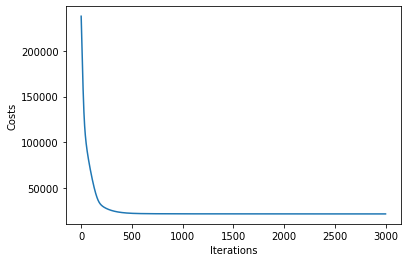

In [ ]:
Train_smote = pd.merge(left = x_smote, right = y_smote,  left_index=True,
                       right_index=True)
Train_smote = np.array(Train_smote, dtype=np.float64)

lr = LogisticRegression(train = Train_smote, test = Test, epsilon=0, 
                        learningRate=0.1e-5, maxIteration=3000)
lr.fit()

In [ ]:
Train_smote = pd.merge(left = x_smote, right = y_smote,  left_index=True,
                       right_index=True)
svm = maxMarginClassifier(C = 5, train = Train_smote, test = Test_SVM)
svm.fit()

Accuracy is  0.713
Confusion Matrix is 
 [[3421 1205]
 [ 517  857]]
F1 Score is  0.49883585564610017
Precision is  0.41561590688651795
Recall is  0.62372634643377


In [ ]:
Train_smote = pd.merge(left = x_smote, right = y_smote,  left_index=True,
                       right_index=True)
ksvm = kernelMaxMarginClassifier(C=5, train=Train_smote, test=Test_SVM, kernel=GRBF)
ksvm.fit()

Accuracy is  0.6255
Confusion Matrix is 
 [[2911 1715]
 [ 532  842]]
F1 Score is  0.428389722716866
Precision is  0.3292921392256551
Recall is  0.6128093158660844


In [ ]:
Train_smote = pd.merge(left = x_smote, right = y_smote,  left_index=True,
                       right_index=True)
gnb = GaussianNaiveBayes(train = Train, test = Test)
gnb.fit()

Accuracy is  0.7186666666666667
Confusion Matrix is 
 [[3560 1066]
 [ 622  752]]
F1 Score is  0.47117794486215536
Precision is  0.4136413641364136
Recall is  0.5473071324599709


In [ ]:
#@title Neural Networks { run: "auto" }


X_train, X_test, y_train, y_test= train_test_split(Train_smote.iloc[:, :-1],
                                                   Train_smote.iloc[:, -1],
                                                   test_size=0.3)
X_val, X_test, y_val, y_test= train_test_split(X_train,y_train,test_size=0.3)



model = Sequential()
# Layers

model.add(Dense(units=512, activation='sigmoid', input_dim=X.shape[1]))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=624, activation='sigmoid'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

valid_accuracy=[]
train_accuracy=[]

for epochs in [50]:
  history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=64, validation_data= (X_val, y_val))
  valid_accuracy.append(model.evaluate(X_val, y_val))
  train_accuracy.append(model.evaluate(X_train, y_train))


# Accuracy and Loss of ANN
train_loss = history.history['loss']
valid_loss   = history.history['val_loss']
train_accuracy  = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

Epoch 1/50
410/410 [==============================] - 6s 13ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 2/50
410/410 [==============================] - 5s 12ms/step - loss: 0.6932 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.5029
Epoch 3/50
410/410 [==============================] - 5s 12ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 4/50
410/410 [==============================] - 5s 12ms/step - loss: 0.6932 - accuracy: 0.4907 - val_loss: 0.6932 - val_accuracy: 0.5019
Epoch 5/50
410/410 [==============================] - 5s 13ms/step - loss: 0.6932 - accuracy: 0.4911 - val_loss: 0.6932 - val_accuracy: 0.5014
Epoch 6/50
410/410 [==============================] - 5s 12ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 7/50
410/410 [==============================] - 5s 13ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5028

## Under-Sampling

The other techniques for creating a balanced dataset is undersampling the majority class. This technique samples exactly same number of points from majority class as there are in minority class. This creates a more generalization of majority class and may run a risk of model underfitting on the dataset.

In [ ]:
from sklearn.utils import resample
Train_Undersample = Train_Balance[Train_Balance.Target == 0]
Train_Minority = Train_Balance[Train_Balance.Target == 1]
Train_Undersample = resample(Train_Undersample, replace=False, 
                             n_samples=len(Train_Balance[Train_Balance.Target == 1]), 
                             random_state=18)
Train_Undersample = pd.concat([Train_Undersample, Train_Minority])
print('Original dataset shape:', Counter(Train_Balance.iloc[:, -1]))
print('Resampled dataset shape:', Counter(Train_Undersample.iloc[:, -1]))

Original dataset shape: Counter({0: 18738, 1: 5262})
Resampled dataset shape: Counter({0: 5262, 1: 5262})


100%|██████████| 4000/4000 [00:08<00:00, 474.10it/s]


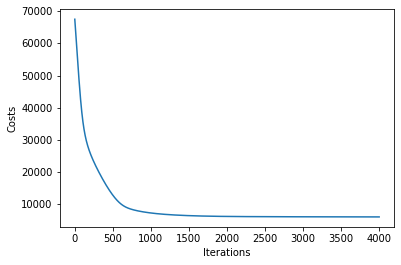

In [ ]:
lr_Train_Undersample = np.array(Train_Undersample, dtype=np.float64)

lr = LogisticRegression(train = lr_Train_Undersample, test = Test, epsilon=0, 
                        learningRate=0.1e-5, maxIteration=4000)
lr.fit()

In [ ]:
#@title SVM For Under-Sampled Data { vertical-output: true }


class maxMarginClassifier:

      def __init__(self, C, train, test):
          self.C = C
          self.train = train
          self.test = test

      def dataReader(self):

        train_df = self.train
        test_df = self.test

        train_X, train_y = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        test_X, test_y = test_df.iloc[:, :-1], test_df.iloc[:, -1]
        train_y = train_y.replace(0, -1)

        train_X = train_X.sample(frac = 0.03, replace = False, 
                                 random_state = 18).to_numpy()
        train_y = train_y.sample(frac = 0.03, replace = False,
                                 random_state = 18).to_numpy()


        return train_X, test_X, train_y, test_y

      def fit(self):

          self.train_X, self.test_X, self.train_y, self.test_y = self.dataReader()
          N = len(self.train_y)
          Xy = self.train_X*self.train_y[:, np.newaxis]
          GramXy = np.matmul(Xy, Xy.T)

          def Ld0(G, alpha):
              obj_fn = alpha.sum() - 0.5*alpha.dot(alpha.dot(G))
              return obj_fn 
          def partialDerivativeLd0(G, alpha):
              par_der = np.ones_like(alpha) - alpha.dot(G)
              return par_der
          
          A = np.vstack((-np.eye(N), np.eye(N)))
          b = concatenate((np.zeros(N), self.C*np.ones(N)))
          constraints = ({'type': 'eq', 'fun': lambda a:np.dot(a, self.train_y), 'jac': lambda a: self.train_y},
                         {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})
          
          alpha = np.ones(N)
          optRes = optimize.minimize(fun = lambda a: -Ld0(GramXy, a),
                                     x0 = alpha,
                                     method = 'SLSQP',
                                     jac = lambda a: -partialDerivativeLd0(GramXy, a),
                                     constraints=constraints)
          
          self.alpha = optRes.x
          self.w = np.sum(self.alpha[:, np.newaxis]*Xy, axis = 0)

          epsilon = 1e-4
          self.supportVectors = self.train_X[self.alpha > epsilon]
          self.supportLabels = self.train_y[self.alpha > epsilon]

          b = []
          for i in range(len(self.supportLabels)):
              b_i = self.supportLabels[i] - np.matmul(self.supportVectors[i].T, self.w)
              b.append(b_i)

          self.intercept = sum(b)/len(b)
          pred = self.predict(self.test_X)
          pred = pred.replace(-1, 0)
          actual = self.test_y
          print('Accuracy is ', metrics.accuracy_score(pred, actual))
          print('Confusion Matrix is \n', metrics.confusion_matrix(actual, pred))
          print('F1 Score is ', metrics.f1_score(actual, pred))
          print('Precision is ', metrics.precision_score(actual, pred))
          print('Recall is ', metrics.recall_score(actual, pred))

      def predict(self, X):
          return 2*(np.matmul(X, self.w) + self.intercept > 0) - 1

In [ ]:
model = maxMarginClassifier(C = 5, train = Train_Undersample, test = Test_SVM)
model.fit()

Accuracy is  0.7311666666666666
Confusion Matrix is 
 [[3623 1003]
 [ 610  764]]
F1 Score is  0.4864692773002228
Precision is  0.43237125070741367
Recall is  0.5560407569141194


In [ ]:
ksvm = kernelMaxMarginClassifier(C=5, train=Train_Undersample, test=Test_SVM, kernel=GRBF)
ksvm.fit()

Accuracy is  0.6653333333333333
Confusion Matrix is 
 [[3378 1248]
 [ 760  614]]
F1 Score is  0.3794808405438813
Precision is  0.3297529538131042
Recall is  0.4468704512372635


In [ ]:
gnb = GaussianNaiveBayes(train = Train_Undersample, test = Test)
gnb.fit()

Accuracy is  0.6755
Confusion Matrix is 
 [[3235 1391]
 [ 556  818]]
F1 Score is  0.4566006140106056
Precision is  0.3703033046627433
Recall is  0.5953420669577875


In [ ]:
#@title Neural Networks { run: "auto" }


X_train, X_test, y_train, y_test= train_test_split(Train_Undersample.iloc[:, :-1],
                                                   Train_Undersample.iloc[:, -1],
                                                   test_size=0.3)
X_val, X_test, y_val, y_test= train_test_split(X_train,y_train,test_size=0.3)


model = Sequential()
# Layers

model.add(Dense(units=512, activation='sigmoid', input_dim=X.shape[1]))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=624, activation='sigmoid'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=32, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

valid_accuracy=[]
train_accuracy=[]

for epochs in [50]:
  history = model.fit(X_train, y_train, epochs=epochs, verbose=1, batch_size=64, validation_data= (X_val, y_val))
  valid_accuracy.append(model.evaluate(X_val, y_val))
  train_accuracy.append(model.evaluate(X_train, y_train))


# Accuracy and Loss of ANN
train_loss = history.history['loss']
valid_loss   = history.history['val_loss']
train_accuracy  = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']


Epoch 1/50
116/116 [==============================] - 2s 13ms/step - loss: 0.6933 - accuracy: 0.4758 - val_loss: 0.6932 - val_accuracy: 0.5017
Epoch 2/50
116/116 [==============================] - 1s 12ms/step - loss: 0.6932 - accuracy: 0.5053 - val_loss: 0.6931 - val_accuracy: 0.5149
Epoch 3/50
116/116 [==============================] - 1s 12ms/step - loss: 0.6932 - accuracy: 0.5043 - val_loss: 0.6930 - val_accuracy: 0.5149
Epoch 4/50
116/116 [==============================] - 2s 15ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6930 - val_accuracy: 0.5149
Epoch 5/50
116/116 [==============================] - 2s 14ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.5149
Epoch 6/50
116/116 [==============================] - 1s 12ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.5149
Epoch 7/50
116/116 [==============================] - 1s 12ms/step - loss: 0.6931 - accuracy: 0.5069 - val_loss: 0.6928 - val_accuracy: 0.5149

# Conclusion


•	From the evaluation of the ML methods, we have applied on the dataset - Logistic Regression, Support Vector Machines, Gaussian Naive Bayes and Neural Networks.

•	SVM, GNB and Neural Networks perform well in this binary classification problem. A point to be noted is the dataset is an unbalanced dataset - so ROC_AUC_score is a better metric to focus on than pure accuracy. In case where balancing techniques are used - the ROC_AUC_score and recall is significantly better than where the data is not balanced. 

•	Most time was spent on understanding nuances of the features from a statistical standpoint and selecting the best ones based on evidence

•	Upscaling was important to elevate our class of interest and SMOTE does a good job

•	Logistic Regression outperforms other algorithms for our case by having high precision and recall values that are also close to each other

•	We note that the best results were obtained when the threshold value for positive classification was over .81 .
